In [1]:
from math import *
import matplotlib
import matplotlib.pyplot as plt
import numpy
import scipy.stats
import scipy.integrate

First, let us define the Gauss-Legendre integration method and run a few simple tests.

In [2]:
def GaussLegendreIntegration(func, lower, upper, degree):
    a = .5 * (upper - lower)
    b = .5 * (upper + lower)
    points_and_weights = numpy.polynomial.legendre.leggauss(degree)
    
    result = 0.
    for point, weight in zip(points_and_weights[0], points_and_weights[1]):
        result += func(b + a * point) * weight
        
    return result*a

In [3]:
deg = 7
print(GaussLegendreIntegration(lambda x : 1. / (1 + x**2), 0, 1, deg) - pi / 4.)
print(GaussLegendreIntegration(lambda x : x, 0, 1, deg) - .5)
print(GaussLegendreIntegration(numpy.exp, 0, 1, deg) - (exp(1) - 1.))

6.659891527149853e-10
0.0
4.440892098500626e-16


Next, we will define the Chebyshev interpolation method and use it to recover an unknown function from values on a few pre specified points.

In [4]:
def ChebyshevInterpolationCoefficients(values):
    size = len(values)
    n = size - 1
    multiplier = 2. / n
    coefficients = [0.] * size
    for i in range(size):
        factor = 1.
        if i is 0 or i is n:
            factor = .5
            
        for j in range(size):
            coefficients[j] += multiplier * factor * values[i] * cos(pi * i * j / n)
            
    return coefficients

In [5]:
ChebyshevInterpolationCoefficients([1,2,3,4,6])

[6.25, -1.9571067811865472, 0.24999999999999956, -0.5428932188134523, 0.25]

In [6]:
def ChebyshevInterpolation(values, z):
    coefficients = ChebyshevInterpolationCoefficients(values)
    size = len(coefficients)
    n = size - 1
    
    result = 0.
    for i in range(size):
        factor = 1.
        if i is 0 or i is n:
            factor = .5
            
        result += factor * coefficients[i] * cos(i * acos(z))
        
    return result

In [7]:
ChebyshevInterpolation([1,2,3,4,6],-1)

5.999999999999998

In [8]:
def TestChebyshev(test_func, lower, upper, degree):
    z = [0.] * degree
    values = [0.] * degree
    for i in range(degree):
        z[i] = cos(pi * i / (degree-1))
        values[i] = test_func(lower + (upper - lower) * .5 * (1. + z[i]))
      
    t = numpy.arange(lower, upper, 0.01)
    s1 = [test_func(x) for x in t]
    s2 = [ChebyshevInterpolation(values, 
                                 2. * (x - lower) / (upper - lower) - 1.) for x in t]
    
    fig, ax = plt.subplots()
    ax.plot(t, s1)
    ax.plot(t, s2)
    plt.show()
      
    for i in range(degree):
        diff = abs(values[i] - ChebyshevInterpolation(values,z[i]))
        print(diff)

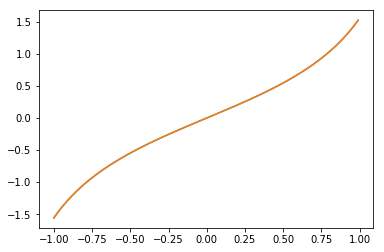

2.220446049250313e-16
2.220446049250313e-16
1.1102230246251565e-16
1.6653345369377348e-16
1.0257883504761298e-16
2.7755575615628914e-16
1.1102230246251565e-16
4.440892098500626e-16
6.661338147750939e-16


In [9]:
test_func = lambda x : tan(x)
TestChebyshev(test_func, -1., 1., 9)

Now, define the ITM probabilities and construct the iteration functions.

In [10]:
def d(boundary, initial, final, vol, pm):
    var = vol * sqrt(final - initial)
    diff = boundary(initial) - boundary(final)
    arg = diff / var + .5 * pm * var
    
    return arg

In [11]:
def d_terminal(boundary, initial, maturity, moneyness, vol, pm):
    var = vol * sqrt(maturity - initial)
    diff = boundary(initial) - moneyness
    arg = diff / var + .5 * pm * var
    
    return arg

In [12]:
def numerator(boundary, 
              moneyness, 
              initial, 
              maturity, 
              vol, 
              discount, 
              discount_deriv, 
              callPut,
              degree):
    result = scipy.stats.norm.cdf(-callPut * d_terminal(boundary,
                                                        initial, 
                                                        maturity, 
                                                        moneyness, 
                                                        vol, 
                                                        -1))
    
    integrand = lambda x: scipy.stats.norm.cdf(-callPut * d(boundary, initial, x, vol, -1)) \
                                           * discount_deriv(x)
    result -= GaussLegendreIntegration(integrand,
                                       initial,
                                       maturity,
                                       degree) / discount(maturity)
                    
    return result                              

In [13]:
def denominator(boundary, 
                moneyness, 
                initial, 
                maturity, 
                vol, 
                discounted_forward, 
                discounted_forward_deriv, 
                callPut,
                degree):
    result = scipy.stats.norm.cdf(-callPut * d_terminal(boundary,
                                                        initial, 
                                                        maturity, 
                                                        moneyness, 
                                                        vol, 
                                                        1))
    
    integrand = lambda x: scipy.stats.norm.cdf(-callPut * d(boundary, initial, x, vol, 1)) \
                                          * discounted_forward_deriv(x)
    result -= GaussLegendreIntegration(integrand,
                                       initial,
                                       maturity,
                                       degree) / discounted_forward(maturity)
                    
    return result                              

From an initial flat exercise boundary, run just one iteration to check the code.

In [30]:
S = 45
K = 45
t = .1
T = .5
vol = .2

r = .05
q = .0

callPut = -1
degree = 11

discount = lambda x: exp(-r * x)
forward = lambda x: S * exp((r-q)*x)
discounted_forward = lambda x: discount(x) * forward(x)

discount_deriv = lambda x: -r * discount(x)
discounted_forward_deriv = lambda x: -q * discounted_forward(x)

moneyness = log(K/forward(T))
boundary = lambda x: moneyness

print(numerator(boundary, 
          moneyness, 
          t, 
          T, 
          vol, 
          discount, 
          discount_deriv, 
          callPut, 
          degree))
print(denominator(boundary, 
            moneyness, 
            t, 
            T, 
            vol, 
            discounted_forward, 
            discounted_forward_deriv, 
            callPut, 
            degree))

0.48454713141323047
0.5252145144244474


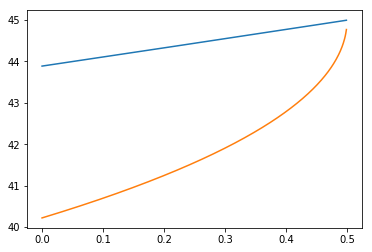

In [31]:
boundary_iter = lambda x: moneyness                \
                        + log(numerator(boundary, 
                                        moneyness, 
                                        x, 
                                        T, 
                                        vol, 
                                        discount, 
                                        discount_deriv, 
                                        callPut,
                                        degree)    \
                             / denominator(boundary, 
                                           moneyness, 
                                           x, 
                                           T, 
                                           vol, 
                                           discounted_forward, 
                                           discounted_forward_deriv, 
                                           callPut,
                                           degree))

t = numpy.arange(0, T, 0.001)
s1 = [forward(x) * exp(boundary(x)) for x in t]
s2 = [forward(x) * exp(boundary_iter(x)) for x in t]

fig, ax = plt.subplots()
ax.plot(t, s1)
ax.plot(t, s2)
plt.show()

In the above single iteration example, we have calculated the early exercise boundary values on a lot of points and then interpolate to form the updated boundary. We will speed up the process by

In [32]:
def SampleValues(boundary,
                 maturity,
                 number_interpolation_points):
    x = [cos(i*pi/(number_interpolation_points-1)) for i in range(number_interpolation_points)]
    return x, [boundary(.5*maturity*(1+y)) for y in x]

In [33]:
points, values = SampleValues(boundary, T, 13)
points, [values[0]] + [boundary_iter(.5*T*(1+x)) for x in points[1:]]

([1.0,
  0.9659258262890683,
  0.8660254037844387,
  0.7071067811865476,
  0.5000000000000001,
  0.25881904510252074,
  6.123233995736766e-17,
  -0.25881904510252063,
  -0.4999999999999998,
  -0.7071067811865475,
  -0.8660254037844387,
  -0.9659258262890682,
  -1.0],
 [-0.025000000000000053,
  -0.039301380660409314,
  -0.05252209937257955,
  -0.06449458696908934,
  -0.07511184462059196,
  -0.0843229601749266,
  -0.09212523667260819,
  -0.09855363076851875,
  -0.10366840970500632,
  -0.10754208052968754,
  -0.11024670720549544,
  -0.11184270060873536,
  -0.11237004290610435])

In [34]:
def EarlyExerciseBoundaryIteration(values,
                                   points,
                                   moneyness,
                                   maturity,
                                   vol,
                                   callPut,
                                   discount,
                                   discount_deriv,
                                   discounted_forward,
                                   discounted_forward_deriv,
                                   number_integration_points):
    boundary_interp = lambda x: ChebyshevInterpolation(values, 2.*x/maturity-1.)
    boundary_iter = lambda x: moneyness                \
                            + log(numerator(boundary_interp, 
                                            moneyness, 
                                            x, 
                                            maturity, 
                                            vol, 
                                            discount, 
                                            discount_deriv, 
                                            callPut,
                                            number_integration_points))    \
                             - log(denominator(boundary_interp, 
                                           moneyness, 
                                           x, 
                                           maturity, 
                                           vol, 
                                           discounted_forward, 
                                           discounted_forward_deriv, 
                                           callPut,
                                           number_integration_points))
    
    return [values[0]] + [boundary_iter(.5*maturity*(1+x)) for x in points[1:]]

In [35]:
def CalculateEarlyExerciseBoundaryByIteration(initial_boundary,
                                              moneyness,
                                              maturity,
                                              vol,
                                              callPut,
                                              discount,
                                              discount_deriv,
                                              discounted_forward,
                                              discounted_forward_deriv,
                                              number_integration_points,
                                              number_interpolation_points,
                                              number_iterations):
    points, values = SampleValues(initial_boundary, maturity, number_interpolation_points)
    new_values = [values]
    for i in range(number_iterations):
        new_values.append(EarlyExerciseBoundaryIteration(new_values[i],
                                                         points,
                                                         moneyness,
                                                         maturity,
                                                         vol,
                                                         callPut,
                                                         discount,
                                                         discount_deriv,
                                                         discounted_forward,
                                                         discounted_forward_deriv,
                                                         number_integration_points))
        
    return new_values

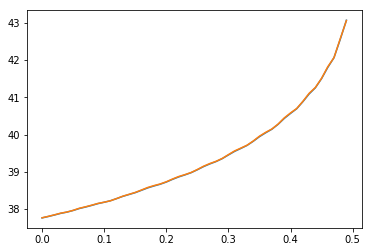

In [37]:
iteration_values = CalculateEarlyExerciseBoundaryByIteration(boundary,
                                          moneyness,
                                          T,
                                          vol,
                                          callPut,
                                          discount,
                                          discount_deriv,
                                          discounted_forward,
                                          discounted_forward_deriv,
                                          13,
                                          35,
                                          8)
    
t = numpy.arange(0, T, 0.01)
fig, ax = plt.subplots()
for iter_values in iteration_values[-3:-1]:
    boundary_interp = lambda x: ChebyshevInterpolation(iter_values, 2.*x/T-1.)
    s = [discounted_forward(x) / discount(x) * exp(boundary_interp(x)) for x in t]
    ax.plot(t, s)

plt.show()

In [23]:
def AmericanOptionPriceFromEarlyExerciseBoundary(boundary):
    pass